In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("/workspaces/scm-co-smart-project/data/raw/DataCoSupplyChainDataset.csv", encoding = 'latin-1' )

In [3]:
# Get basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [4]:
# Create function to rename columns' name
def rename_column(name):
    name = name.lower()
    name = re.sub(r"[^\w]+", "_", name)
    name = name.strip("_")
    return name

In [5]:
# rename columns
df.columns = [rename_column(column) for column in df.columns]

In [6]:
# rename columns: order_date_dateorders --> order_date and shipping_date_dateorders --> shipping_date
df.rename(columns={'order_date_dateorders': 'order_date'}, inplace=True)
df.rename(columns={'shipping_date_dateorders': 'shipping_date'}, inplace=True)

In [7]:
# convert date columns if needed
df['order_date'] = pd.to_datetime(df['order_date'])
df['shipping_date'] = pd.to_datetime(df['shipping_date'])

In [8]:
df.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_email', 'customer_fname', 'customer_id',
       'customer_lname', 'customer_password', 'customer_segment',
       'customer_state', 'customer_street', 'customer_zipcode',
       'department_id', 'department_name', 'latitude', 'longitude', 'market',
       'order_city', 'order_country', 'order_customer_id', 'order_date',
       'order_id', 'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_item_total', 'order_profit_per_order', 'order_region',
       'order_state', 'order_status', 'order_zipcode', 'product_card_id',
       'product_category_id', 'product_description', 'product_ima

In [9]:
# detect missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_table = pd.DataFrame({
    "missing_values": missing_values,
    "missing_percent": missing_percent
})
missing_table = missing_table[missing_table["missing_values"] > 0]

print(missing_table)

                     missing_values  missing_percent
customer_lname                    8         0.004432
customer_zipcode                  3         0.001662
order_zipcode                155679        86.239676
product_description          180519       100.000000


In [10]:
# for customer_lname and customer_zipcode --> MCAR
df = df.dropna(subset=["customer_lname", "customer_zipcode"])

In [11]:
# for product_description - no values --> drop the whole columns
df = df.drop(['product_description'], axis = 1)

In [12]:
# for order_zipcode - optional data field --> drop the whole columns
df = df.drop(['order_zipcode'], axis = 1)

In [13]:
# Customers related columns analysis
# drop unnecessary columns
df = df.drop(['customer_email' , 'customer_password'], axis = 1)

In [14]:
# Frequency count in customer_country
df['customer_country'].value_counts()

customer_country
EE. UU.        111137
Puerto Rico     69371
Name: count, dtype: int64

In [15]:
# Find out that all customers come from the USA --> can drop the customer_country column
df = df.drop(['customer_country'], axis = 1)

In [23]:
# Frequency count in customer_state
state_count = df['customer_state'].value_counts()
state_percent = (state_count / len(df)) * 100
state_table = pd.DataFrame({
    "state_count": state_count,
    "state_percent": state_percent
})

In [ ]:
# Bar chart for Customer - States Distribution
plt.figure(figsize=(5,3))
state_count.head(20).plot(kind='bar', color = 'skyblue')
plt.title("Top 20 Customer - States Distribution")
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.show()

In [ ]:
# Order related columns analysis

# order_status
df['order_status'].value_counts()
order_status_count = df['order_status'].value_counts()

# bar chart for Order Status Distribution
plt.figure(figsize=(5,3))
order_status_count.plot(kind='barh', color='skyblue')
plt.title("Order Status Distribution")
plt.xlabel("Number of Orders")
plt.ylabel("Order Status")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# order_region 
df['order_region'].value_counts()
region_count = df['order_region'].value_counts()

# bar chart for Order Region Distribution
plt.figure(figsize=(5,3))
region_count.plot(kind='barh', color='skyblue')
plt.title("Order Region Distribution")
plt.xlabel("Number of Orders")
plt.ylabel("Region")
plt.gca().invert_yaxis()  # region lớn nhất lên trên
plt.show()

In [31]:
# create new year, quarter, month, day_name, time columns
df['order_year'] = df['order_date'].dt.year
df['order_quarter'] = df['order_date'].dt.quarter
df['order_month'] = df['order_date'].dt.month
df['order_day_name'] = df['order_date'].dt.day_name()
df['order_hour'] = df['order_date'].dt.hour

In [24]:
# frequency count in order_year --> the dataset is from 2015 - 2018
df['order_year'].value_counts()

order_year
2015    62650
2016    62550
2017    53186
2018     2122
Name: count, dtype: int64

In [25]:
# as 2018 order amount is less than previous year --> check --> 2018 Jan only 
df.loc[df['order_year'] == 2018, 'order_month'].value_counts()

order_month
1    2122
Name: count, dtype: int64

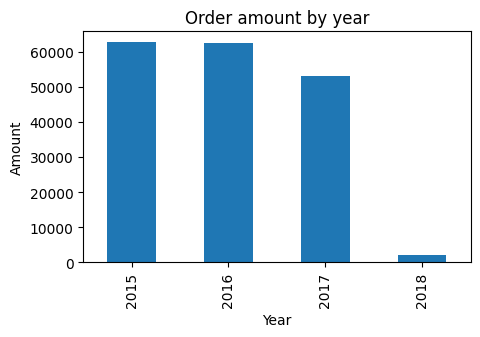

In [35]:
# bar chart for order_year
plt.figure(figsize=(5,3))
df['order_year'].value_counts().sort_index().plot(kind='bar')
plt.title("Order amount by year")
plt.xlabel("Year")
plt.ylabel("Amount")
plt.show()

In [27]:
# frequency count in order_quater
df['order_quarter'].value_counts()

order_quarter
1    48426
3    47323
2    46550
4    38209
Name: count, dtype: int64

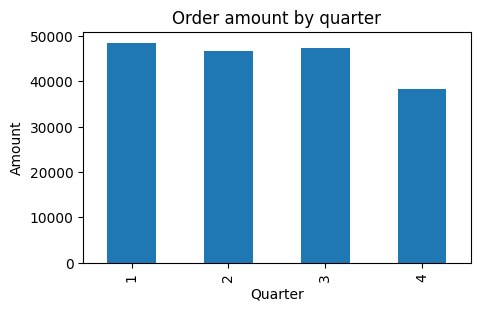

In [36]:
# bar chart for order_quarter
plt.figure(figsize=(5,3))
df['order_quarter'].value_counts().sort_index().plot(kind='bar')
plt.title("Order amount by quarter")
plt.xlabel("Quarter")
plt.ylabel("Amount")
plt.show()

In [28]:
# frequency count in order_month
df['order_month'].value_counts()

order_month
1     17978
5     15976
7     15922
3     15919
8     15912
9     15489
4     15435
6     15139
2     14529
10    12953
12    12759
11    12497
Name: count, dtype: int64

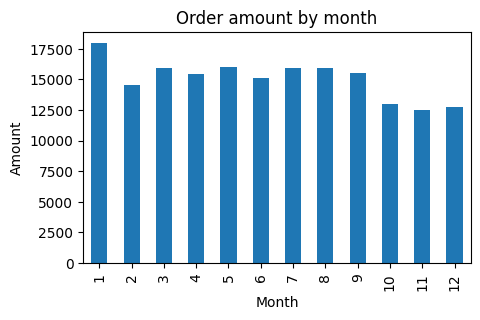

In [37]:
# bar chart for order_month
plt.figure(figsize=(5,3))
df['order_month'].value_counts().sort_index().plot(kind='bar')
plt.title("Order amount by month")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.show()

In [29]:
# frequency count in order_day_name
df['order_day_name'].value_counts()

order_day_name
Sunday       25945
Friday       25925
Saturday     25900
Monday       25786
Thursday     25748
Tuesday      25619
Wednesday    25585
Name: count, dtype: int64

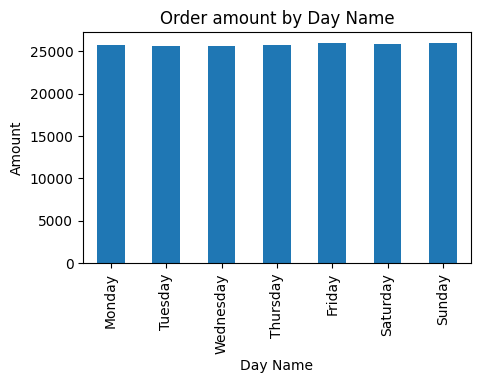

In [39]:
# bar chart for order_day_name
plt.figure(figsize=(5,3))
df['order_day_name'].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
).plot(kind='bar')
plt.title("Order amount by Day Name")
plt.xlabel("Day Name")
plt.ylabel("Amount")
plt.show()

In [32]:
# frequency count in order_hour
df['order_hour'].value_counts()

order_hour
4     7719
10    7697
5     7591
0     7589
13    7578
2     7574
23    7573
17    7573
1     7558
14    7555
19    7552
18    7533
7     7517
9     7505
16    7500
11    7497
12    7486
20    7480
15    7471
3     7440
8     7434
22    7418
21    7398
6     7270
Name: count, dtype: int64

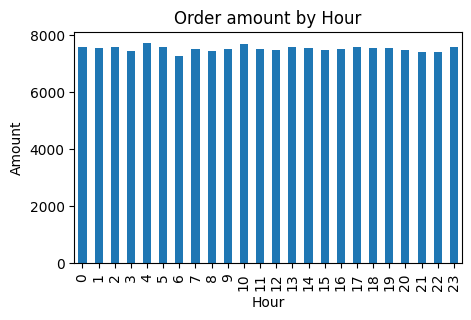

In [40]:
# bar chart for order_hour
plt.figure(figsize=(5,3))
df['order_hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Order amount by Hour")
plt.xlabel("Hour")
plt.ylabel("Amount")
plt.show()

In [ ]:
# → The order distributions across different quarters, months, days, and hours appear quite similar. 
# This suggests that the dataset may not reflect real-world seasonality or time-based trends, 
# but rather is a balanced sample created for study purposes.